In [162]:
import numpy as np
from scipy.optimize import minimize
from scipy.io import loadmat
from math import sqrt
from sklearn.feature_selection import VarianceThreshold
from sklearn.datasets import fetch_openml
import pandas as pd


def initializeWeights(n_in, n_out):
    """
    # initializeWeights return the random weights for Neural Network given the
    # number of node in the input layer and output layer

    # Input:
    # n_in: number of nodes of the input layer
    # n_out: number of nodes of the output layer
       
    # Output: 
    # W: matrix of random initial weights with size (n_out x (n_in + 1))"""

    epsilon = sqrt(6) / sqrt(n_in + n_out + 1)
    W = (np.random.rand(n_out, n_in + 1) * 2 * epsilon) - epsilon
    return W


def sigmoid(z):
    """# Notice that z can be a scalar, a vector or a matrix
    # return the sigmoid of input z"""

    return 1 / (1 + np.exp(-z))


def preprocess():
    """ 
    Input:
    Although this function doesn't have any input, you are required to load
    the MNIST data set from file 'mnist_all.mat'.

    Output:
    train_data: matrix of training set. Each row of train_data contains 
      feature vector of a image
    train_label: vector of label corresponding to each image in the training
      set
    validation_data: matrix of training set. Each row of validation_data 
      contains feature vector of a image
    validation_label: vector of label corresponding to each image in the 
      training set
    test_data: matrix of training set. Each row of test_data contains 
      feature vector of a image
    test_label: vector of label corresponding to each image in the testing
      set
    """

    mat = loadmat('mnist_all.mat')  # loads the MAT object as a Dictionary

    # Initialize preprocess arrays
    train_preprocess = np.zeros(shape=(50000, 784))
    validation_preprocess = np.zeros(shape=(10000, 784))
    test_preprocess = np.zeros(shape=(10000, 784))
    train_label_preprocess = np.zeros(shape=(50000,))
    validation_label_preprocess = np.zeros(shape=(10000,))
    test_label_preprocess = np.zeros(shape=(10000,))

    train_len = 0
    validation_len = 0
    test_len = 0
    train_label_len = 0
    validation_label_len = 0

    # Start to split the data set into arrays
    for key in mat:
        if "train" in key:
            label = key[-1]
            tup = mat.get(key)
            sap = range(tup.shape[0])
            tup_perm = np.random.permutation(sap)
            tup_len = len(tup)
            tag_len = tup_len - 1000  # Number of examples for training

            # Add data to training set
            train_preprocess[train_len:train_len + tag_len] = tup[tup_perm[1000:], :]
            train_len += tag_len

            train_label_preprocess[train_label_len:train_label_len + tag_len] = np.full(tag_len, label)
            train_label_len += tag_len

            # Add data to validation set
            validation_preprocess[validation_len:validation_len + 1000] = tup[tup_perm[0:1000], :]
            validation_len += 1000

            validation_label_preprocess[validation_label_len:validation_label_len + 1000] = np.full(1000, label)
            validation_label_len += 1000

        elif "test" in key:
            label = key[-1]
            tup = mat.get(key)
            sap = range(tup.shape[0])
            tup_perm = np.random.permutation(sap)
            tup_len = len(tup)
            test_label_preprocess[test_len:test_len + tup_len] = np.full(tup_len, label)
            test_preprocess[test_len:test_len + tup_len] = tup[tup_perm]
            test_len += tup_len

    # Shuffle, double and normalize
    train_size = range(train_preprocess.shape[0])
    train_perm = np.random.permutation(train_size)
    train_data = train_preprocess[train_perm]
    train_data = np.double(train_data) / 255.0
    train_label = train_label_preprocess[train_perm]

    validation_size = range(validation_preprocess.shape[0])
    vali_perm = np.random.permutation(validation_size)
    validation_data = validation_preprocess[vali_perm]
    validation_data = np.double(validation_data) / 255.0
    validation_label = validation_label_preprocess[vali_perm]

    test_size = range(test_preprocess.shape[0])
    test_perm = np.random.permutation(test_size)
    test_data = test_preprocess[test_perm]
    test_data = np.double(test_data) / 255.0
    test_label = test_label_preprocess[test_perm]

    # Feature selection
    # Remove constant features using VarianceThreshold
    selector = VarianceThreshold(threshold=0) 
    train_data_cleaned = selector.fit_transform(train_data)
    validation_data_cleaned = selector.transform(validation_data) 
    test_data_cleaned = selector.transform(test_data)


    # Get the remaining feature indices
    remaining_feature_indices = selector.get_support(indices=True)

    # print(f"Number of selected features: {len(remaining_feature_indices)}")
    # print(f"Selected feature indices: {remaining_feature_indices}")
  

    # Select the relevant columns based on valid indices
    train_data_selected = train_data_cleaned
    validation_data_selected = validation_data_cleaned
    test_data_selected = test_data_cleaned



    print('Preprocessing done')

    return train_data_selected, train_label, validation_data_selected, validation_label, test_data_selected, test_label

def nnObjFunction(params, *args):
    """Compute the value of the objective function (negative log 
    likelihood error function with regularization) for a neural network.

    Parameters:
    params: vector of weights of 2 matrices w1 (input to hidden) and w2 (hidden to output)
    n_input: number of nodes in input layer (excluding bias)
    n_hidden: number of nodes in hidden layer (excluding bias)
    n_class: number of nodes in output layer (number of classes)
    training_data: matrix of training data (each row is a feature vector)
    training_label: vector of truth labels for training images
    lambda: regularization hyper-parameter

    Returns:
    obj_val: scalar value representing the error function
    obj_grad: SINGLE vector of gradient values of the error function
    """
    
    n_input, n_hidden, n_class, training_data, training_label, lambda_ = args

    # Reshape params into weight matrices w1 and w2
    w1 = params[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))
    w2 = params[n_hidden * (n_input + 1):].reshape((n_class, (n_hidden + 1)))

    m = training_data.shape[0]  # Number of training samples
    training_label = training_label.astype(int).flatten()  # Ensure it's 1D
  

    # Forward propagation
    x_bias = np.hstack((np.ones((m, 1)), training_data))  # Add bias to input layer
    pre_hidden = x_bias.dot(w1.T)
    post_hidden = sigmoid(pre_hidden)
    hidden_bias = np.hstack((np.ones((m, 1)), post_hidden))  # Add bias to hidden layer
    pre_output = hidden_bias.dot(w2.T)
    post_output = softmax(pre_output)

    # Compute objective function
    y_encode = np.zeros((m, n_class))
    y_encode[np.arange(m), training_label] = 1 
    loss = -np.sum(y_encode * np.log(post_output)) / m
    regularize_cal = (lambda_ / (2 * m)) * (np.sum(w1[:, 1:] ** 2) + np.sum(w2[:, 1:] ** 2))
    objective_cal = loss + regularize_cal

    # Backpropagation
    delta_output = post_output - y_encode  # Error at output layer
    gradient_W2 = (delta_output.T.dot(hidden_bias) / m) + (lambda_ * np.hstack((np.zeros((n_class, 1)), w2[:, 1:]))) / m

    delta_hidden = delta_output.dot(w2[:, 1:]) * post_hidden * (1 - post_hidden)  # Error at hidden layer
    gradient_W1 = (delta_hidden.T.dot(x_bias) / m) + (lambda_ * np.hstack((np.zeros((n_hidden, 1)), w1[:, 1:]))) / m

    # Flatten the gradients
    objective_grad = np.concatenate([gradient_W1.flatten(), gradient_W2.flatten()])

    return objective_cal, objective_grad


def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / exp_z.sum(axis=1, keepdims=True)
    
def nnPredict(w1, w2, data):
    """% nnPredict predicts the label of data given the parameter w1, w2 of Neural
    % Network.

    % Input:
    % w1: matrix of weights of connections from input layer to hidden layers.
    %     w1(i, j) represents the weight of connection from unit i in input 
    %     layer to unit j in hidden layer.
    % w2: matrix of weights of connections from hidden layer to output layers.
    %     w2(i, j) represents the weight of connection from unit i in input 
    %     layer to unit j in hidden layer.
    % data: matrix of data. Each row of this matrix represents the feature 
    %       vector of a particular image
       
    % Output: 
    % label: a column vector of predicted labels"""

    labels = np.array([])
    # Your code here
    m = data.shape[0]
    data_bias = np.hstack((np.ones((m, 1)), data))  # Add bias column

    pre_hidden = data_bias.dot(w1.T)  
    post_hidden = sigmoid(pre_hidden)
    post_hidden_with_bias = np.hstack((np.ones((m, 1)), post_hidden)) 

    pre_output = post_hidden_with_bias.dot(w2.T)  
    post_output = sigmoid(pre_output)

    labels = np.argmax(post_output, axis=1)
    return labels

In [164]:
"""**************Neural Network Script Starts here********************************"""

train_data, train_label, validation_data, validation_label, test_data, test_label = preprocess()

Preprocessing done


In [166]:
print("Shape of Train Features: {}".format(train_data.shape))
print("Shape of Test Features: {}".format(train_label.shape))
print("Shape of Train Target: {}".format(test_data.shape))


Shape of Train Features: (50000, 713)
Shape of Test Features: (50000,)
Shape of Train Target: (10000, 713)


In [168]:
#  Train Neural Network

# set the number of nodes in input unit (not including bias unit)
n_input = train_data.shape[1]

# set the number of nodes in hidden unit (not including bias unit)
n_hidden = 35

# set the number of nodes in output unit
n_class = 10

# initialize the weights into some random matrices
initial_w1 = initializeWeights(n_input, n_hidden)
initial_w2 = initializeWeights(n_hidden, n_class)

# unroll 2 weight matrices into single column vector
initialWeights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()), 0)

# set the regularization hyper-parameter
lambdaval = 0.01

args = (n_input, n_hidden, n_class, train_data, train_label, lambdaval)

# Train Neural Network using fmin_cg or minimize from scipy,optimize module. Check documentation for a working example

opts = {'maxiter': 50}  # Preferred value.

In [170]:
nn_params = minimize(nnObjFunction, initialWeights, jac=True, args=args, method='CG', options=opts)

In [171]:
print(f"Shape of training_data: {train_data.shape}")  # Should be (m, n_input)
print(f"Shape of training_label: {train_label.shape}")

Shape of training_data: (50000, 713)
Shape of training_label: (50000,)


In [172]:

# In Case you want to use fmin_cg, you may have to split the nnObjectFunction to two functions nnObjFunctionVal
# and nnObjGradient. Check documentation for this function before you proceed.
# nn_params, cost = fmin_cg(nnObjFunctionVal, initialWeights, nnObjGradient,args = args, maxiter = 50)


# Reshape nnParams from 1D vector into w1 and w2 matrices
w1 = nn_params.x[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))
w2 = nn_params.x[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))

print(w1)
print(w2)

[[-0.69670745  0.03007732 -0.04386091 ...  0.05283236  0.06988981
  -0.05117902]
 [-0.37860433  0.05340758  0.06116091 ...  0.05913726 -0.07469374
   0.020202  ]
 [ 0.75492412 -0.00892363  0.07289551 ...  0.01077974  0.06247481
   0.05060665]
 ...
 [-0.22609948 -0.08780765  0.0404846  ... -0.06712135  0.05821907
  -0.00999551]
 [-0.02171411 -0.02671695  0.03780306 ... -0.05411118  0.07250884
   0.02880435]
 [ 0.28820239 -0.0856475  -0.08386065 ... -0.03676992  0.0084607
  -0.03937251]]
[[-0.39996613  2.31486945  0.53206698  1.51169989  1.49584045 -1.45167176
  -0.70430601 -0.52259315 -0.2848423  -1.00881252 -0.96417507 -0.89209118
  -2.33474969 -0.6051521  -1.37369495  1.26730349  0.19668013 -1.43755446
   0.7863375   0.83080054 -1.12095488 -0.33938714  0.05720557 -1.72404058
   0.10973758 -1.55962634  0.54973588 -2.73366074  1.51155054 -1.3753972
   1.84277209 -0.52867942  2.73669431 -1.01891409  0.63202882 -0.50985738]
 [-0.23820164 -1.59602719  0.16380373 -0.52004962 -1.19234459  0.

In [173]:
# Test the computed parameters

predicted_label = nnPredict(w1, w2, train_data)
print ('\n MNIST')
print('\n Training set Accuracy:' + str(100 * np.mean((predicted_label == train_label).astype(float))) + '%')
predicted_label = nnPredict(w1, w2, validation_data)

# find the accuracy on Validation Dataset

print('\n Validation set Accuracy:' + str(100 * np.mean((predicted_label == validation_label).astype(float))) + '%')

predicted_label = nnPredict(w1, w2, test_data)

# find the accuracy on Validation Dataset

print('\n Test set Accuracy:' + str(100 * np.mean((predicted_label == test_label).astype(float))) + '%')


 MNIST

 Training set Accuracy:96.574%

 Validation set Accuracy:95.1%

 Test set Accuracy:95.65%


λ=0, Validation Accuracy: 0.9426
λ=10, Validation Accuracy: 0.9444
λ=20, Validation Accuracy: 0.9402
λ=30, Validation Accuracy: 0.9361
λ=40, Validation Accuracy: 0.9374
λ=50, Validation Accuracy: 0.9345
λ=60, Validation Accuracy: 0.9302


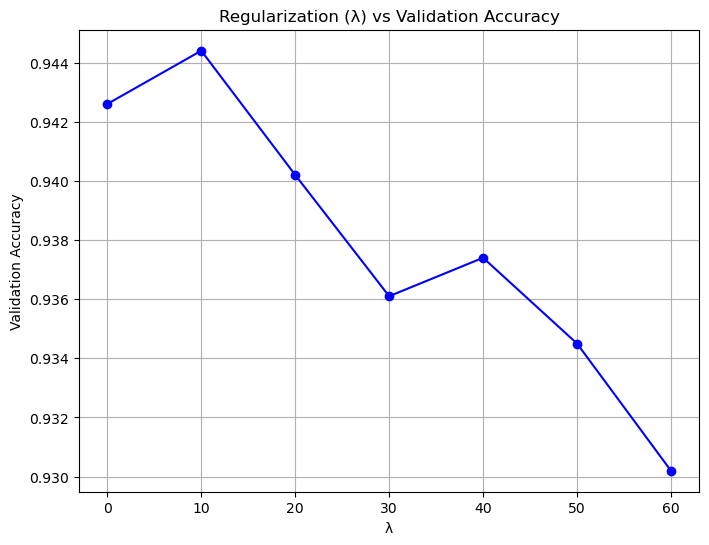

In [174]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import time

lambdas = np.arange(0, 61, 10) 
hidden = 8  
val_accuracies_lambda = [] 

for lambda_val in lambdas:
    # Initialize weights
    initial_w1 = initializeWeights(n_input, n_hidden)
    initial_w2 = initializeWeights(n_hidden, n_class)
    initialWeights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()), 0)

    # Define arguments for optimization
    args = (n_input, n_hidden, n_class, train_data, train_label, lambda_val)
    
    # Train the neural network
    start_time = time.time()
    opts = {'maxiter': 50}  # Maximum iterations
    nn_params = minimize(nnObjFunction, initialWeights, jac=True, args=args, method='CG', options=opts)
    training_time = time.time() - start_time
    
    # Extract optimized weights
    params = nn_params.get('x')
    w1 = params[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))
    w2 = params[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))

    # Make predictions on validation set
    predicted_labels = nnPredict(w1, w2, validation_data)
    
    # Calculate accuracy on validation set
    accuracy = np.mean(predicted_labels == validation_label)
    
    # Append the accuracy for this λ value
    val_accuracies_lambda.append(accuracy)
    print(f"λ={lambda_val}, Validation Accuracy: {accuracy}")

# Plot λ vs validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(lambdas, val_accuracies_lambda, marker='o', color='b')
plt.title("Regularization (λ) vs Validation Accuracy")
plt.xlabel("λ")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()


Hidden Units=5, Validation Accuracy: 0.8628, Training Time: 8.52s
Hidden Units=10, Validation Accuracy: 0.9217, Training Time: 11.34s
Hidden Units=15, Validation Accuracy: 0.9251, Training Time: 14.65s
Hidden Units=20, Validation Accuracy: 0.9318, Training Time: 17.59s
Hidden Units=25, Validation Accuracy: 0.94, Training Time: 18.74s
Hidden Units=30, Validation Accuracy: 0.9425, Training Time: 16.98s
Hidden Units=35, Validation Accuracy: 0.9433, Training Time: 18.45s
Hidden Units=40, Validation Accuracy: 0.9516, Training Time: 23.36s
Hidden Units=45, Validation Accuracy: 0.945, Training Time: 24.39s
Hidden Units=50, Validation Accuracy: 0.9432, Training Time: 25.12s
Hidden Units=55, Validation Accuracy: 0.9465, Training Time: 24.08s
Hidden Units=60, Validation Accuracy: 0.9476, Training Time: 59.47s
Hidden Units=65, Validation Accuracy: 0.9476, Training Time: 2401.21s
Hidden Units=70, Validation Accuracy: 0.9452, Training Time: 2106.72s
Hidden Units=75, Validation Accuracy: 0.9428, Tra

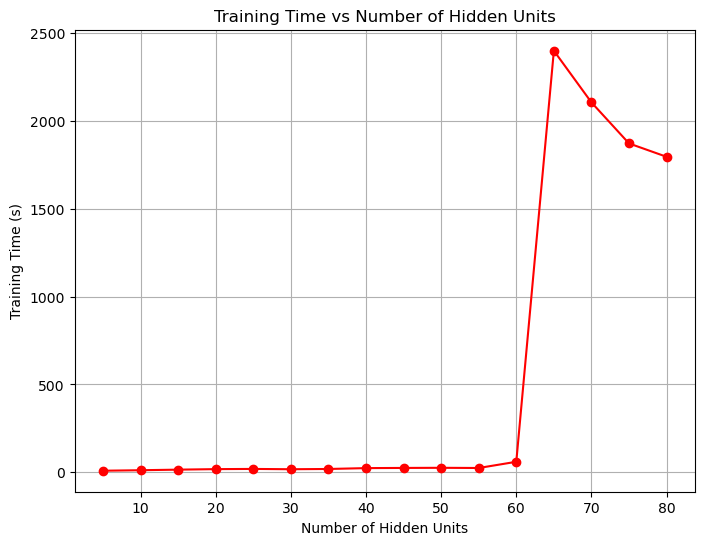

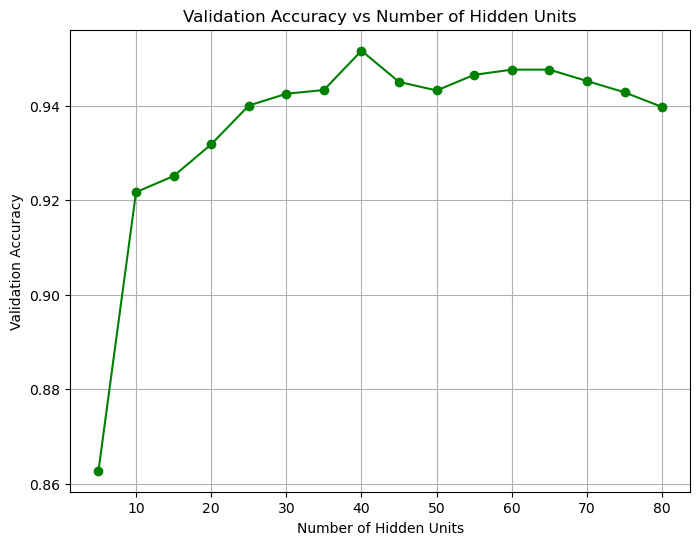

In [175]:
hidden_units_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]  # Different numbers of hidden units
train_times_hidden = []  # List to store training times
val_accuracies_hidden = []  # List to store validation accuracies for each hidden unit size

# Fixed λ for this experiment
lambda_val = 10

# Loop over different numbers of hidden units
for n_hidden in hidden_units_list:
    # Initialize weights
    initial_w1 = initializeWeights(n_input, n_hidden)
    initial_w2 = initializeWeights(n_hidden, n_class)
    initialWeights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()), 0)
    
    # Define arguments for optimization
    args = (n_input, n_hidden, n_class, train_data, train_label, lambda_val)
    
    # Measure training time and train the network
    start_time = time.time()
    opts = {'maxiter': 50}  # Maximum iterations
    nn_params = minimize(nnObjFunction, initialWeights, jac=True, args=args, method='CG', options=opts)
    training_time = time.time() - start_time
    
    # Extract optimized weights
    params = nn_params.get('x')
    w1 = params[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))
    w2 = params[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))
    
    # Make predictions on validation set
    predicted_labels = nnPredict(w1, w2, validation_data)
    
    # Calculate accuracy on validation set
    accuracy = np.mean(predicted_labels == validation_label)
    
    # Store results
    train_times_hidden.append(training_time)
    val_accuracies_hidden.append(accuracy)
    print(f"Hidden Units={n_hidden}, Validation Accuracy: {accuracy}, Training Time: {training_time:.2f}s")

# Plot training time vs number of hidden units
plt.figure(figsize=(8, 6))
plt.plot(hidden_units_list, train_times_hidden, marker='o', color='r')
plt.title("Training Time vs Number of Hidden Units")
plt.xlabel("Number of Hidden Units")
plt.ylabel("Training Time (s)")
plt.grid(True)
plt.show()

# Plot validation accuracy vs number of hidden units
plt.figure(figsize=(8, 6))
plt.plot(hidden_units_list, val_accuracies_hidden, marker='o', color='g')
plt.title("Validation Accuracy vs Number of Hidden Units")
plt.xlabel("Number of Hidden Units")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()
